<a href="https://colab.research.google.com/github/dattali18/IR_Assignments/blob/main/Assignment.02/notebooks/IR_02_Clustering_Doc2Vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clustering

## 1. Objective

Take the document (meaning vector representation of the document, the ouput of the last assginment `Doc2Vec`, `BERT`, `Sentence-BERT`, times 4 group from each) and cluster them into groups and compare the results with the actuale division form each publication.

## 2. Input

4 Groups of matrices each line repesent a document in it's vector form, from:

1. `Doc2Vec`
2. `BERT`
3. `Sentence-BERT`

### 3. Task

  - Combine the four matrices into a single matrix for each technique.
  - Apply clustering using:
    - **K-Means** (with `k=4` for 4 journals).
    - **DBSCAN** (select `eps` and `min_samples` heuristically).
    - **Gaussian Mixture Model**.
  - Evaluate the clusters using:
    - Metrics: Precision, Recall, F1-Score, Accuracy.
    - Visualization: Use UMAP, t-SNE, or other tools (e.g., Seaborn).


### 4. Output

- The plot of the real clusters vs. the clusters from the 3 methods mentioned above.
- The metrics for each clustering method.

# Doc2Vec Matrices

We have 4 `.csv` files with each $(100, \approx 600)$ and we need to combine them into one big matrix and then cluster them.

## Plan

1. Download the files from my `GitHub`.
2. Add a `'cluster'` column for each file (`=0` for AJ etc...).
3. Cluster with `Kmeans` for `k=4`.
4. Write a function to find the right parameters for 4 clusters for `DBSCAN` (i.e. the `eps` and `min_samples` parameters).
5. Cluster with `DBSCAN`
6. Cluster with `GMM`
7. Use `t-SNE` to visualize the cluster in $\mathbb{R}^2$
8. Output the plot for each clustering methods + original
9. Measure each method using the metric mentioned above.

In [ ]:
import warnings

warnings.filterwarnings("ignore")

In [ ]:
base_url = "https://raw.githubusercontent.com/dattali18/IR_Assignments/refs/heads/main/Assignment.01/output/doc2vec/"

file_names = ["aj", "bbc", "jp", "nyt"]

cluster_map =  {'aj' : 0, 'bbc': 1, 'jp' : 2, 'nyt': 3}

links = [f"{base_url}/{name}_doc2vec.csv" for name in file_names]

In [ ]:
import pandas as pd

dfs = {}

for name, link in zip(file_names, links):
    df = pd.read_csv(link)
    # take all the col from 0 - 99 and put them into a numpy array
    df_cpy = pd.DataFrame()
    df_cpy['vector'] = df.iloc[:, :100].to_numpy().tolist()
    df_cpy["cluster"] = cluster_map[name]
    dfs[name] = df_cpy

In [ ]:
dfs['aj'].head()

,vector,cluster
0,"[-0.16861272, 0.13619465, 0.118086584, 0.04930...",0
1,"[-0.1352571, 0.11357225, 0.09048813, 0.0408173...",0
2,"[-0.061645806, 0.055493645, 0.045198712, 0.019...",0
3,"[-0.11881534, 0.09667818, 0.07898884, 0.034127...",0
4,"[-0.04435978, 0.04531823, 0.03259423, 0.011060...",0


In [ ]:
# merge all of the df into one df

df = pd.concat(dfs.values(), ignore_index=True)

In [ ]:
# standerdize the data mean=0 std=1

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# apply to each line of the df

df['std_vector'] = df['vector'].apply(lambda x: scaler.fit_transform(np.array(x).reshape(-1, 1)).flatten())
df['std_vector'].head()

,std_vector
0,"[-0.9614479972007641, 0.6957987565937652, 0.59..."
1,"[-0.9792962849264775, 0.7375863705340073, 0.57..."
2,"[-0.9016816118502328, 0.7442563640622617, 0.59..."
3,"[-1.0004149361896462, 0.7354988385819545, 0.59..."
4,"[-0.8834392389517144, 0.8111157942320139, 0.57..."


In [ ]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture

import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns

In [ ]:
# visualize the real cluster using t-SNE

from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0)

# transofrm the df['vector'] to dataframe with freatuer 0 - 99 for
df_copy = df['std_vector'].apply(pd.Series)

df_tsne = tsne.fit_transform(df_copy)

df_tsne = pd.DataFrame(df_tsne, columns=['x', 'y'])

df_tsne['cluster'] = df['cluster']

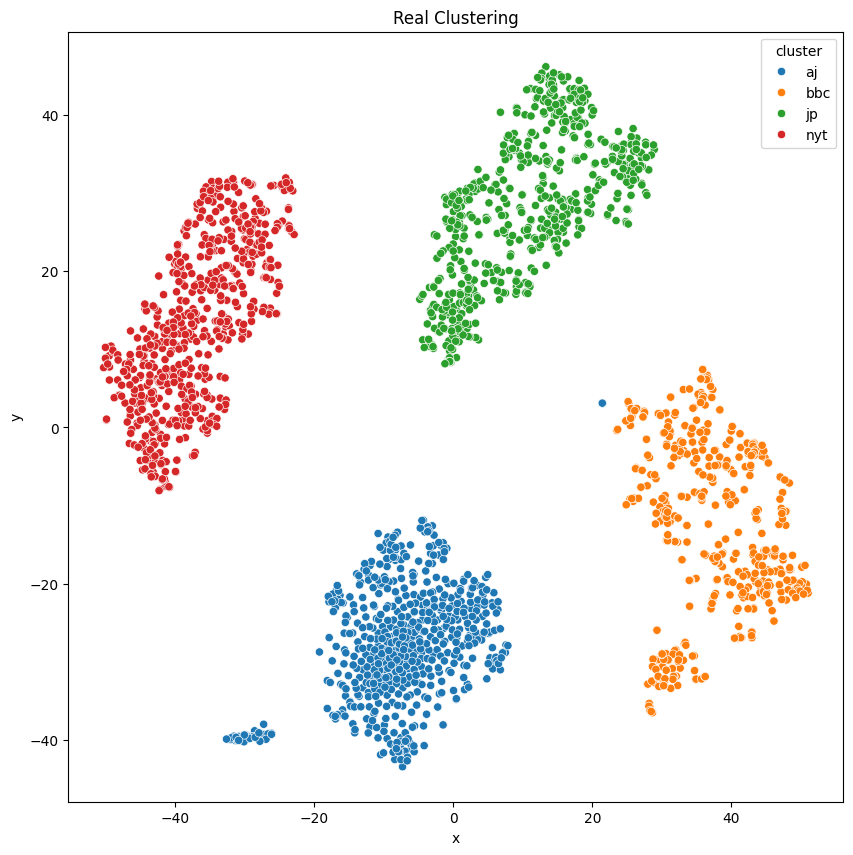

In [ ]:
# plot the df_tsne

reverse_cluster_map = {v: k for k, v in cluster_map.items()}

plt.figure(figsize=(10, 10))
# add labels
plt.title('Real Clustering')

# make color scheme red, blue, green etc


df_tsne['cluster'] = df_tsne['cluster'].map(reverse_cluster_map)

sns.scatterplot(data=df_tsne, x='x', y='y', hue='cluster')

plt.show()

### Kmeans

In [ ]:
kmeans = KMeans(n_clusters=4, random_state=0).fit(df['std_vector'].tolist())

df['cluster_kmeans'] = kmeans.labels_

df['cluster_kmeans'].head()

,cluster_kmeans
0,3
1,3
2,3
3,3
4,3


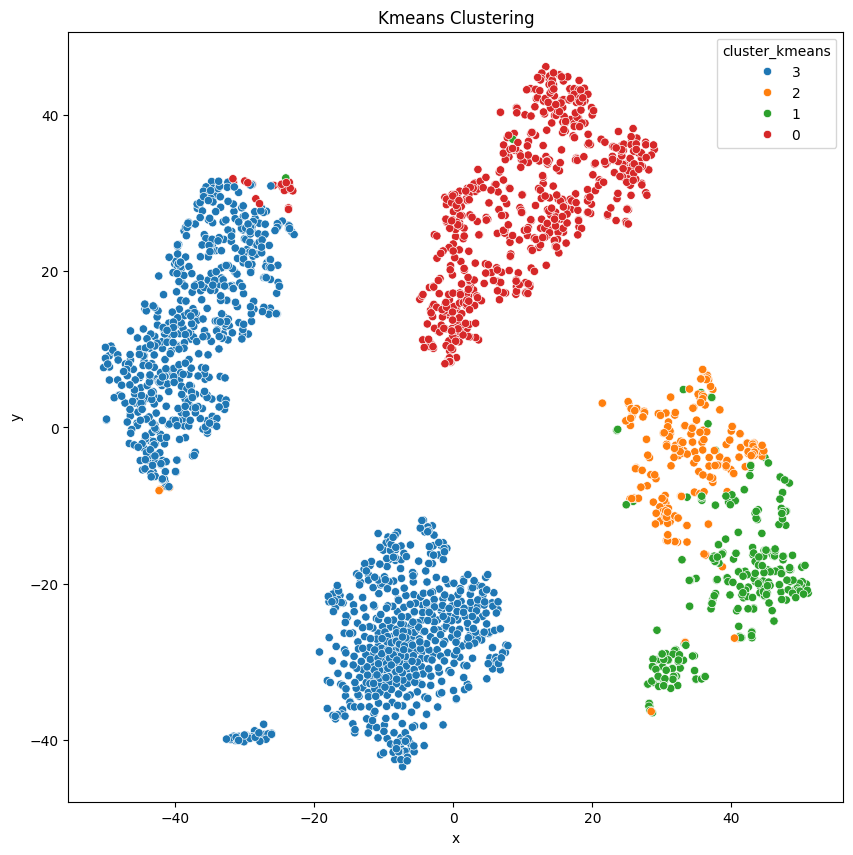

In [ ]:
# visutalize the cluster using the t-SNE df

df_tsne['cluster_kmeans'] = df['cluster_kmeans']

reverse_cluster_map = {v: k for k, v in cluster_map.items()}

plt.figure(figsize=(10, 10))

plt.title('Kmeans Clustering')

# make color scheme red, blue, green etc


df_tsne['cluster_kmeans'] = df_tsne['cluster_kmeans'].map(str)

sns.scatterplot(data=df_tsne, x='x', y='y', hue='cluster_kmeans')

plt.show()

### DBSCAN

In [ ]:
!pip install kneed

In [ ]:
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from kneed import KneeLocator
from sklearn.cluster import DBSCAN

def get_parameters(df, num_clusters=4, eps_adjustment=1.0, min_samples_adjustment=1):
    X = np.array(df)

    # Use NearestNeighbors to find the nearest neighbors
    neighbors = NearestNeighbors(n_neighbors=2 * X.shape[1] - 1)
    neighbors_fit = neighbors.fit(X)
    distances, indices = neighbors_fit.kneighbors(X)
    distances = np.sort(distances, axis=0)
    distances = distances[:, 1]

    # Use KneeLocator to find the "elbow" point in the k-distance graph
    kneedle = KneeLocator(range(len(distances)), distances, S=1.0, curve="convex", direction="increasing")
    eps = distances[kneedle.elbow] * eps_adjustment

    # Set min_samples to 2 * dimensions, another common heuristic
    min_samples = 2 * X.shape[1] * min_samples_adjustment

    return eps, min_samples

def find_best_parameters(df, num_clusters=4):
    best_eps = None
    best_min_samples = None
    best_num_clusters = 0

    for eps_adjustment in np.arange(0.5, 2.0, 0.1):
        for min_samples_adjustment in range(1, 5):
            eps, min_samples = get_parameters(df, num_clusters, eps_adjustment, min_samples_adjustment)
            db = DBSCAN(eps=eps, min_samples=min_samples).fit(df)
            labels = db.labels_
            num_clusters_found = len(set(labels)) - (1 if -1 in labels else 0)

            if num_clusters_found == num_clusters:
                return eps, min_samples

            if num_clusters_found > best_num_clusters:
                best_eps = eps
                best_min_samples = min_samples
                best_num_clusters = num_clusters_found

    return best_eps, best_min_samples

eps, min_samples = find_best_parameters(df['std_vector'].tolist(), num_clusters=4)
print(f"Best eps: {eps}, Best min_samples: {min_samples}")

Best eps: 2.744350773278325, Best min_samples: 200


In [ ]:
# use DBSCAN

dbscan = DBSCAN(eps=eps, min_samples=min_samples).fit(df['std_vector'].tolist())

df['cluster_dbscan'] = dbscan.labels_

In [ ]:
# count the number of cluster

num_clusters = len(df['cluster_dbscan'].unique())

print(f"Number of clusters: {num_clusters}")

Number of clusters: 3


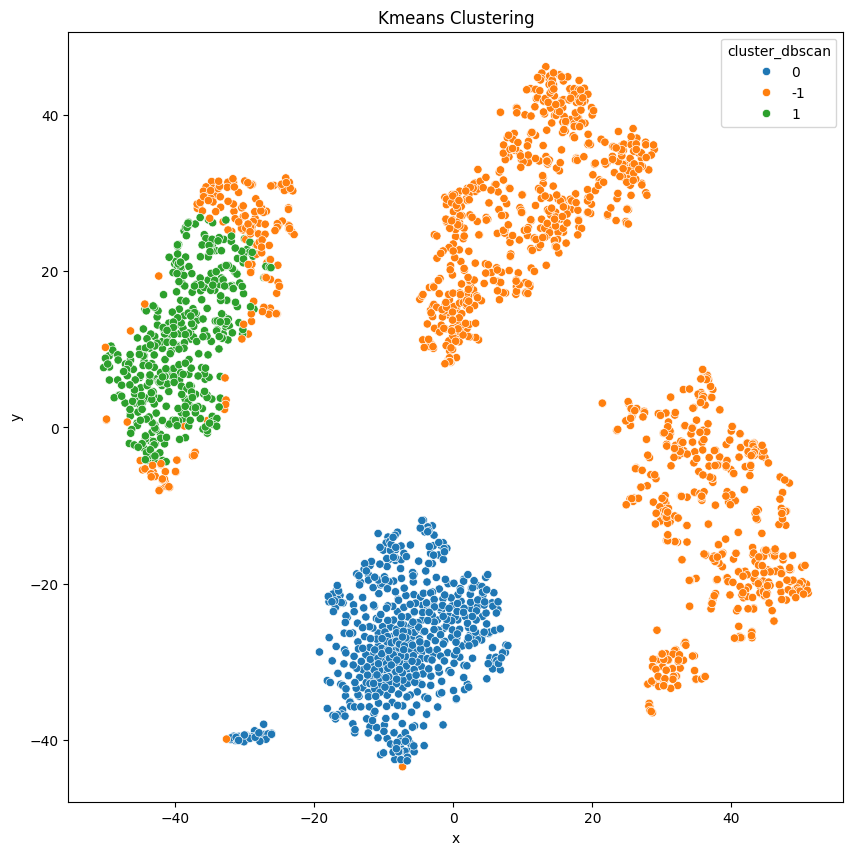

In [ ]:
# visualize data

# visutalize the cluster using the t-SNE df

df_tsne['cluster_dbscan'] = df['cluster_dbscan']

reverse_cluster_map = {v: k for k, v in cluster_map.items()}

plt.figure(figsize=(10, 10))

plt.title('DBSCAN Clustering')

# make color scheme red, blue, green etc


df_tsne['cluster_dbscan'] = df_tsne['cluster_dbscan'].map(str)

sns.scatterplot(data=df_tsne, x='x', y='y', hue='cluster_dbscan')

plt.show()

### GMM

In [ ]:
# apply GMM

gmm = GaussianMixture(n_components=4, random_state=0).fit(df['std_vector'].tolist())

df['cluster_gmm'] = gmm.predict(df['std_vector'].tolist())

df['cluster_gmm'].head()


,cluster_gmm
0,3
1,3
2,3
3,3
4,3


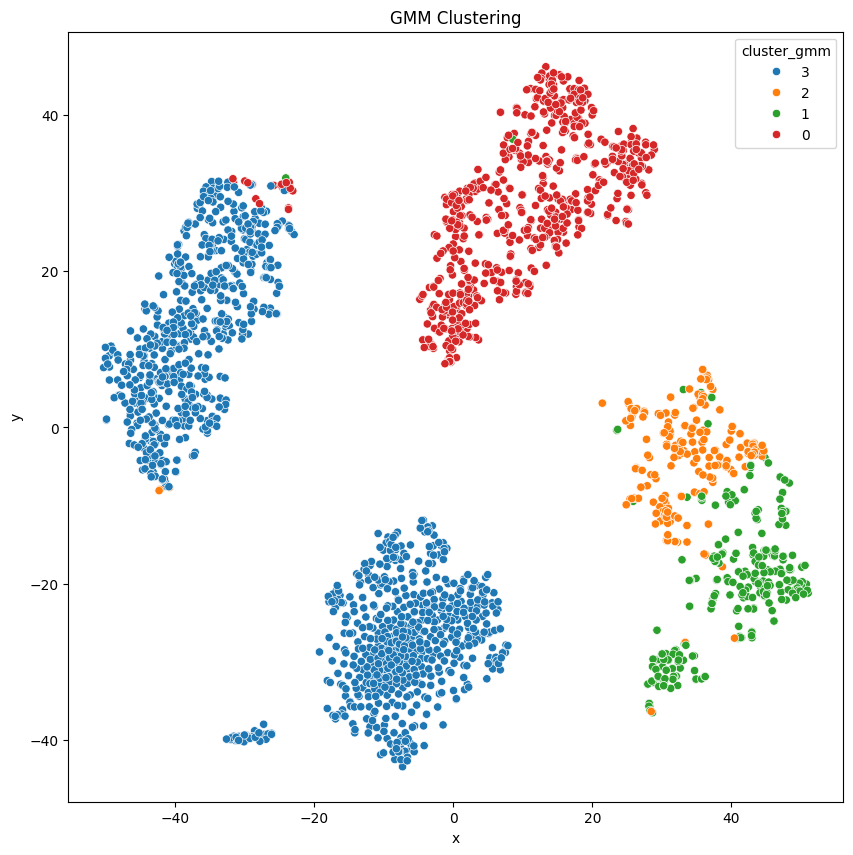

In [ ]:
# visualize data

# visutalize the cluster using the t-SNE df

df_tsne['cluster_gmm'] = df['cluster_gmm']

reverse_cluster_map = {v: k for k, v in cluster_map.items()}

plt.figure(figsize=(10, 10))

plt.title('GMM Clustering')

# make color scheme red, blue, green etc


df_tsne['cluster_gmm'] = df_tsne['cluster_gmm'].map(str)

sns.scatterplot(data=df_tsne, x='x', y='y', hue='cluster_gmm')

plt.show()

## Measurements

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

def evluate_model(real, pred):
    precision = precision_score(real, pred, average='macro')
    recall = recall_score(real, pred, average='macro')
    f1 = f1_score(real, pred, average='macro')
    accuracy = accuracy_score(real, pred)

    return precision, recall, f1, accuracy

In [ ]:
kmeans_evalutation_df = pd.DataFrame(columns=['precision', 'recall', 'f1', 'accuracy'])

kmeans_evalutation_df.loc['kmeans'] = evluate_model(df['cluster'], df['cluster_kmeans'])

kmeans_evalutation_df

,precision,recall,f1,accuracy
kmeans,0.37066,0.374432,0.337265,0.370844


In [ ]:
# same for DBSCAN but map -1 to 2
df['cluster_dbscan'] = df['cluster_dbscan'].map(lambda x: x if x != -1 else 2)

dbscan_evalutation_df = pd.DataFrame(columns=['precision', 'recall', 'f1', 'accuracy'])

dbscan_evalutation_df.loc['dbscan'] = evluate_model(df['cluster'], df['cluster_dbscan'])

dbscan_evalutation_df

,precision,recall,f1,accuracy
dbscan,0.362509,0.498331,0.404344,0.508951


In [ ]:
# same for GMM

gmm_evalutation_df = pd.DataFrame(columns=['precision', 'recall', 'f1', 'accuracy'])

gmm_evalutation_df.loc['gmm'] = evluate_model(df['cluster'], df['cluster_gmm'])

gmm_evalutation_df

,precision,recall,f1,accuracy
gmm,0.370775,0.375305,0.337838,0.371697
